In [1]:
import pandas as pd
from matplotlib import pyplot as plt
from aosol.armazenamento.bomba_calor_aqs import BombaCalorAqs, ModoOperacaoBombaCalor, ParametrosBombaCalor
from aosol.armazenamento.perfil_extraccao import PerfilExtraccao, TipoPerfil
import aosol.analise.analise_bomba_calor as abc
import aosol.analise.analise_energia as ae
from datetime import timedelta
from tabulate import tabulate

## Parâmetros Bomba Calor

In [2]:
# Deposito
##########
vol = 0.152           # volume (m3)
bU = 0.5              # local deposito
u = 1.023*vol + 1.293 # coeficiente perda deposito [W]
u_kw = u/1000         # kW/ºC
t_int = 20.0          # temperatura no interior

# Bomba Calor
############# 
pot_termica_bc = 1.55 # Potência termica BC
pot_resist = 1.5      # Potência resistênia
cop = 3.6             # COP BC

params = ParametrosBombaCalor()
params.SP1 = 52.0        # Setpoint em modo economico
params.SP2 = 60.0        # Setpoint em modo conforto
params.SP3 = 45.0        # Setpoint activacao Boost
params.SP5 = 55.0        # Setpoint paragem bomba calor
params.SP6 = 65.0        # Setpoint em modo PV
params.r0 = 5.0          # Diferencial de setpoint
params.r7 = 15.0         # Diferencial resistencia em modo conforto
params.usa_resist = False # Em modo economico se resistencia é activada abaixo SP3
params.modo = ModoOperacaoBombaCalor.ECO  # Modo operação

bc = BombaCalorAqs(pot_termica_bc, cop, pot_resist, params, vol, bU)

## Perfis extracção AQS

Text(0, 0.5, 'Energia [kWh]')

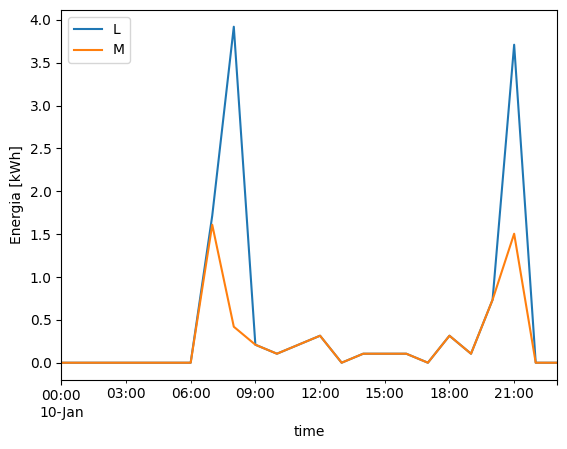

In [3]:
df = pd.DataFrame({'time': ['01-10-2020 00:00:00', '01-10-2020 01:00:00', '01-10-2020 02:00:00', '01-10-2020 03:00:00', 
    '01-10-2020 04:00:00', '01-10-2020 05:00:00', '01-10-2020 06:00:00', '01-10-2020 07:00:00', '01-10-2020 08:00:00', 
    '01-10-2020 09:00:00', '01-10-2020 10:00:00', '01-10-2020 11:00:00', '01-10-2020 12:00:00', '01-10-2020 13:00:00', 
    '01-10-2020 14:00:00', '01-10-2020 15:00:00', '01-10-2020 16:00:00', '01-10-2020 17:00:00', '01-10-2020 18:00:00', 
    '01-10-2020 19:00:00', '01-10-2020 20:00:00', '01-10-2020 21:00:00', '01-10-2020 22:00:00', '01-10-2020 23:00:00']})
df['time'] = pd.to_datetime(df['time'])

perfilL = PerfilExtraccao(TipoPerfil.L)
perfilM = PerfilExtraccao(TipoPerfil.M)

df['L'] = df['time'].apply(lambda x: perfilL.extraccao_aqs_intervalo(x))
df['M'] = df['time'].apply(lambda x : perfilM.extraccao_aqs_intervalo(x))

ax = df.plot(x='time', y='L')
df.plot(x='time',y='M', ax=ax)
ax.set_ylabel('Energia [kWh]')

## Temperatura exterior

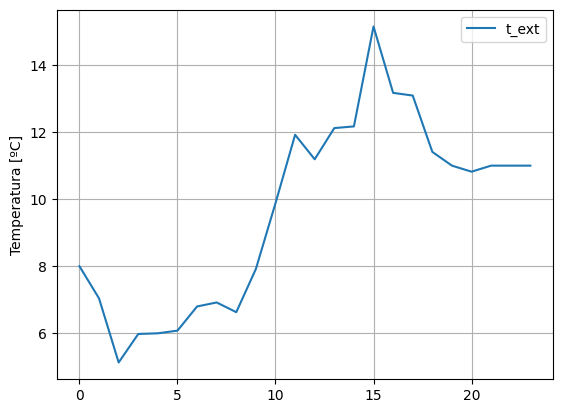

In [4]:
temp = pd.DataFrame({'t_ext':[8.0, 7.04, 5.13, 5.98, 6.0, 6.08, 6.8, 6.92, 6.63, 7.92, 9.88,
        11.92, 11.19, 12.12, 12.17, 15.15, 13.17, 13.09, 11.41, 11.0, 10.82, 11.0, 11.0, 11.0]})

ax = temp.plot(y='t_ext')
ax.set_ylabel('Temperatura [ºC]')
plt.grid()

## Temperatura sala do depósito ($T_{s,room}$)

Temperatura do local onde se encontra o depósito, determina as perdas do depósito para o ambiente

$b_U$ : factor de redução de temperatura.
* 0: depósito num local aquecido
* 1: depósito no exterior
* 0.5: depoósito interior em local não aquecido, ex. cave, sotão.

$T_{s,room}(i) = T_{INT} - b_U \left[ T_{INT} - T_{EXT}(i) \right]$



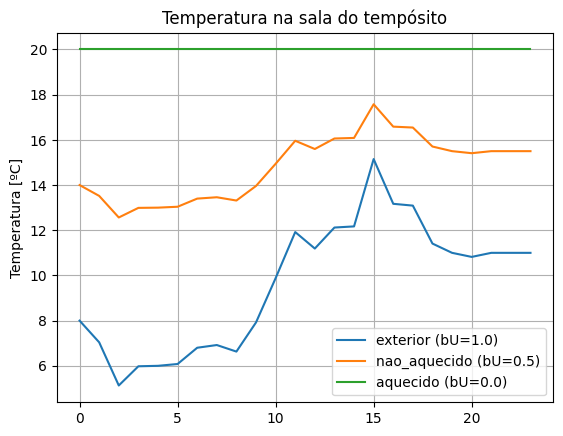

In [5]:
t_dep = temp['t_ext'].to_frame()
t_dep['exterior (bU=1.0)'] = t_int - 1.0*(t_int - t_dep['t_ext'])
t_dep['nao_aquecido (bU=0.5)'] = t_int - 0.5*(t_int - t_dep['t_ext'])
t_dep['aquecido (bU=0.0)'] = t_int - 0.0*(t_int - t_dep['t_ext'])

ax = t_dep.plot(y=['exterior (bU=1.0)', 'nao_aquecido (bU=0.5)', 'aquecido (bU=0.0)'])
ax.set_ylabel('Temperatura [ºC]')
ax.set_title('Temperatura na sala do tempósito')
plt.grid()

## Simulação perfil extracção L

* Constroi caso com 2 dias
* Avalia os 2 casos com resistência e sem
* Deposito localizado em cave (bu = 0.5)

In [6]:
dia1 = df['time'].to_frame()
dia1['e_extr_aqs'] = df['L']
dia1['t_ext'] = t_dep['t_ext']
dia1['t_sala'] = t_dep['nao_aquecido (bU=0.5)'] 

dia2 = df['time'].to_frame()
dia2['time'] = dia2['time']+timedelta(days=1)
dia2['e_extr_aqs'] = df['L']
dia2['t_ext'] = t_dep['t_ext']
dia2['t_sala'] = t_dep['nao_aquecido (bU=0.5)']

sim1 = pd.concat([dia1, dia2], axis=0)
sim1 = sim1.set_index('time')

In [7]:
# Simulacao sem resistencia
params.usa_resist = False
sim1_sem_resist = sim1.copy()
sim1_sem_resist['modo_op'] = ModoOperacaoBombaCalor.ECO
sim1_sem_resist = abc.analisa_consumo_bomba_calor(sim1_sem_resist, bc, t_int, perfilL, 45.0)

params.usa_resist = True
sim1_com_resist = sim1.copy()
sim1_com_resist['modo_op'] = ModoOperacaoBombaCalor.ECO
sim1_com_resist = abc.analisa_consumo_bomba_calor(sim1_com_resist, bc, t_int, perfilL, 45.0)

sim1_aut = sim1.copy()
sim1_aut['modo_op'] = ModoOperacaoBombaCalor.AUT
sim1_aut = abc.analisa_consumo_bomba_calor(sim1_aut, bc, t_int, perfilL, 45.0)

sim1_pv = sim1.copy()
params.usa_resist = False
sim1_pv['modo_op'] = ModoOperacaoBombaCalor.ECO
sim1_pv.loc[sim1_pv.between_time('09:00','16:00').index, 'modo_op'] = ModoOperacaoBombaCalor.PV
sim1_pv = abc.analisa_consumo_bomba_calor(sim1_pv, bc, t_int, perfilL, 45.0)


### Plots

In [8]:
def plot_evolucao_deposito(ax1, df, titulo, t_max_s, t_min_s):
    ax1s = ax1.twinx()
    df.plot(y=['t_deposito'],ax=ax1, c='r')
    ax1.axhline(y=t_max_s, color='black', linestyle='--',label='t_max_s')
    ax1.axhline(y=t_min_s, color='black', linestyle='--', label='t_min_s')
    ax1.set_ylim([0, 66])
    df.plot(y=['energia_bc','energia_resist'], ax=ax1s)
    ax1.set_ylabel('Temperatura [ºC]')
    ax1s.set_ylim([0, 5])
    ax1s.set_ylabel('Energia [kWh]')
    ax1.set_title(titulo)
    ax1.grid()

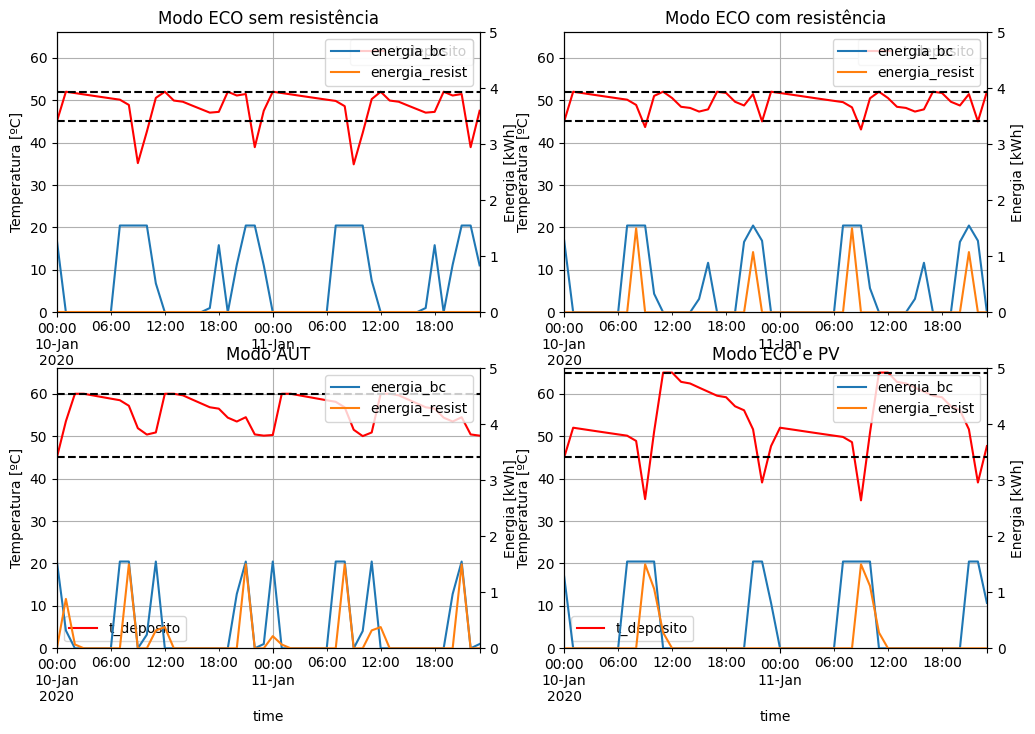

In [9]:
p,ax = plt.subplots(2, 2, figsize=(12,8))
ax1 = ax[0,0]
plot_evolucao_deposito(ax1, sim1_sem_resist, 'Modo ECO sem resistência', params.SP1, params.SP3)

ax2 = ax[0,1]
plot_evolucao_deposito(ax2, sim1_com_resist, 'Modo ECO com resistência', params.SP1, params.SP3)

ax3 = ax[1,0]
plot_evolucao_deposito(ax3, sim1_aut, 'Modo AUT', params.SP2, params.SP3)

ax4 = ax[1,1]
plot_evolucao_deposito(ax4, sim1_pv, 'Modo ECO e PV', params.SP6, params.SP3)

### Stats

In [10]:
stats = pd.DataFrame()
stats1 = abc.calcula_indicadores_bomba_calor(sim1_sem_resist, params.SP3).to_frame("eco sem resist")
stats = pd.concat([stats, stats1], axis=1)

stats2 = abc.calcula_indicadores_bomba_calor(sim1_com_resist, params.SP3).to_frame("eco com resist")
stats = pd.concat([stats, stats2], axis=1)

stats3 = abc.calcula_indicadores_bomba_calor(sim1_aut, params.SP3).to_frame("aut")
stats = pd.concat([stats, stats3], axis=1)

stats4 = abc.calcula_indicadores_bomba_calor(sim1_pv, params.SP3).to_frame("eco+pv")
stats = pd.concat([stats, stats4], axis=1)
print(tabulate(stats, headers='keys', tablefmt='github', missingval='-', floatfmt=('.1f', '.1f', '.1f', '.1f', '.2f', '.2f', '.0f')))

| quant                                |   eco sem resist |   eco sem resist [p/dia] |   eco com resist |   eco com resist [p/dia] |   aut |   aut [p/dia] |    eco+pv |   eco+pv [p/dia] |
|--------------------------------------|------------------|--------------------------|------------------|--------------------------|-------|---------------|-----------|------------------|
| Energia termica BC [kWh]             |             26.9 |                     13.4 |             21.8 |                    10.88 | 18.46 |             9 | 21.5029   |         10.7514  |
| Consumo electrico BC [kWh]           |              7.7 |                      3.9 |              6.3 |                     3.13 |  5.35 |             3 |  6.02156  |          3.01078 |
| Consumo electrico Resistencia [kWh]  |              0.0 |                      0.0 |              5.2 |                     2.58 |  8.63 |             4 |  5.74066  |          2.87033 |
| Perda ambient depósito [kWH]         |              2.3 | 